In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt


In [2]:
CFG = {
    "ROOT": Path("."),

    # files
    "EVAL_NAME": "eval.json",
    "EPT_NAME":  "ept.json",

    # 5-run KD folders
    "KD_GROUPS": {
        "FEATURE":   [f"FEATURE/MODEL {i}" for i in range(1, 6)],
        "RESPONSE":  [f"RESPONSE/MODEL {i}" for i in range(1, 6)],
        "RELATION":  [f"RELATION/MODEL {i}" for i in range(1, 6)],
    },

    # single baselines
    "BASELINES": {
        "Teacher":     "BASE/TEACHER",
        "Student":     "BASE/STUDENT",
        "Traditional": "TRADITIONAL STUDENT",
    },

    # order in table/plot
    "ORDER": ["Teacher", "Student", "Traditional", "FEATURE", "RESPONSE", "RELATION"],

    # metric preference for accuracy inside eval.json
    "METRIC_KEYS": ["acc_norm,none", "acc,none", "acc_norm", "acc"],

    # save figs
    "OUTDIR": Path("figures"),
    "BASENAME": "eff_overall",
}


In [3]:
def read_json(p: Path) -> dict:
    return json.loads(p.read_text(encoding="utf-8"))

def extract_avg_accuracy(eval_path: Path, metric_keys) -> float:
    obj = read_json(eval_path)

    # lm-eval style: obj["results"][task][metric_key]
    res = obj.get("results", {})
    vals = []

    if isinstance(res, dict):
        for task_name, task_block in res.items():
            if not isinstance(task_block, dict):
                continue
            found = None
            for k in metric_keys:
                if k in task_block and task_block[k] is not None:
                    found = float(task_block[k])
                    break
            if found is not None:
                vals.append(found)

    if not vals:
        sample_task = next(iter(res.keys())) if isinstance(res, dict) and res else None
        sample_keys = list(res[sample_task].keys()) if sample_task else []
        raise KeyError(
            f"No usable accuracy metric in {eval_path}\n"
            f"Top keys: {list(obj.keys())[:12]}\n"
            f"Sample task: {sample_task}\n"
            f"Sample keys: {sample_keys[:25]}\n"
            f"Tried: {list(metric_keys)}"
        )

    return float(np.mean(vals))

def extract_ept_total(ept_path: Path) -> float:
    obj = read_json(ept_path)
    for k in ["EPT_total_J_per_tok", "ept_total_J_per_tok", "EPT_total"]:
        if k in obj and obj[k] is not None:
            return float(obj[k])
    raise KeyError(f"No EPT_total key in {ept_path}. Keys: {list(obj.keys())[:25]}")


In [4]:
def load_single_metrics(root: Path, folder: str, cfg: dict) -> tuple[float, float]:
    eval_p = root / folder / cfg["EVAL_NAME"]
    ept_p  = root / folder / cfg["EPT_NAME"]
    acc = extract_avg_accuracy(eval_p, cfg["METRIC_KEYS"])
    ept = extract_ept_total(ept_p)
    return acc, ept

def load_group_metrics(root: Path, folders: list[str], cfg: dict) -> tuple[np.ndarray, np.ndarray]:
    accs, epts = [], []
    for f in folders:
        a, e = load_single_metrics(root, f, cfg)
        accs.append(a); epts.append(e)
    return np.array(accs, float), np.array(epts, float)

def build_eff_overall_table(cfg: dict) -> pd.DataFrame:
    root = cfg["ROOT"]

    # teacher references
    acc_teacher, ept_teacher = load_single_metrics(root, cfg["BASELINES"]["Teacher"], cfg)

    rows = []
    # Teacher row (by definition: OM_perf=1, ratio=1 => Eff=1)
    rows.append({
        "Method": "Teacher",
        "Acc_avg": acc_teacher,
        "EPT_total": ept_teacher,
        "OM_perf_avg": 1.0,
        "Eff_overall": 1.0,
        "n": 1,
        "std_eff": 0.0,
    })

    # Single baselines (Student, Traditional)
    for m in ["Student", "Traditional"]:
        acc, ept = load_single_metrics(root, cfg["BASELINES"][m], cfg)
        om = acc / acc_teacher
        eff = om * (ept_teacher / ept)
        rows.append({
            "Method": m,
            "Acc_avg": acc,
            "EPT_total": ept,
            "OM_perf_avg": om,
            "Eff_overall": eff,
            "n": 1,
            "std_eff": 0.0,
        })

    # KD groups (5 runs each)
    for kd, folders in cfg["KD_GROUPS"].items():
        accs, epts = load_group_metrics(root, folders, cfg)
        om_i  = accs / acc_teacher
        eff_i = om_i * (ept_teacher / epts)

        rows.append({
            "Method": kd,
            "Acc_avg": float(accs.mean()),
            "EPT_total": float(epts.mean()),
            "OM_perf_avg": float(om_i.mean()),
            "Eff_overall": float(eff_i.mean()),
            "n": int(len(folders)),
            "std_eff": float(eff_i.std()),
        })

    df = pd.DataFrame(rows)
    df["Method"] = pd.Categorical(df["Method"], categories=cfg["ORDER"], ordered=True)
    df = df.sort_values("Method").reset_index(drop=True)
    return df

eff_df = build_eff_overall_table(CFG)
eff_df


,Method,Acc_avg,EPT_total,OM_perf_avg,Eff_overall,n,std_eff
0,Teacher,0.794155,354.750412,1.000000,1.000000,1,0.000000
1,Student,0.681143,0.332404,0.857695,915.356616,1,0.000000
2,Traditional,0.677436,0.342757,0.853027,882.874942,1,0.000000
3,FEATURE,0.249895,0.445042,0.314668,250.853457,5,5.793490
4,RESPONSE,0.636377,0.486516,0.801326,584.345699,5,5.888968
5,RELATION,0.644412,0.461016,0.811444,624.477951,5,8.542450


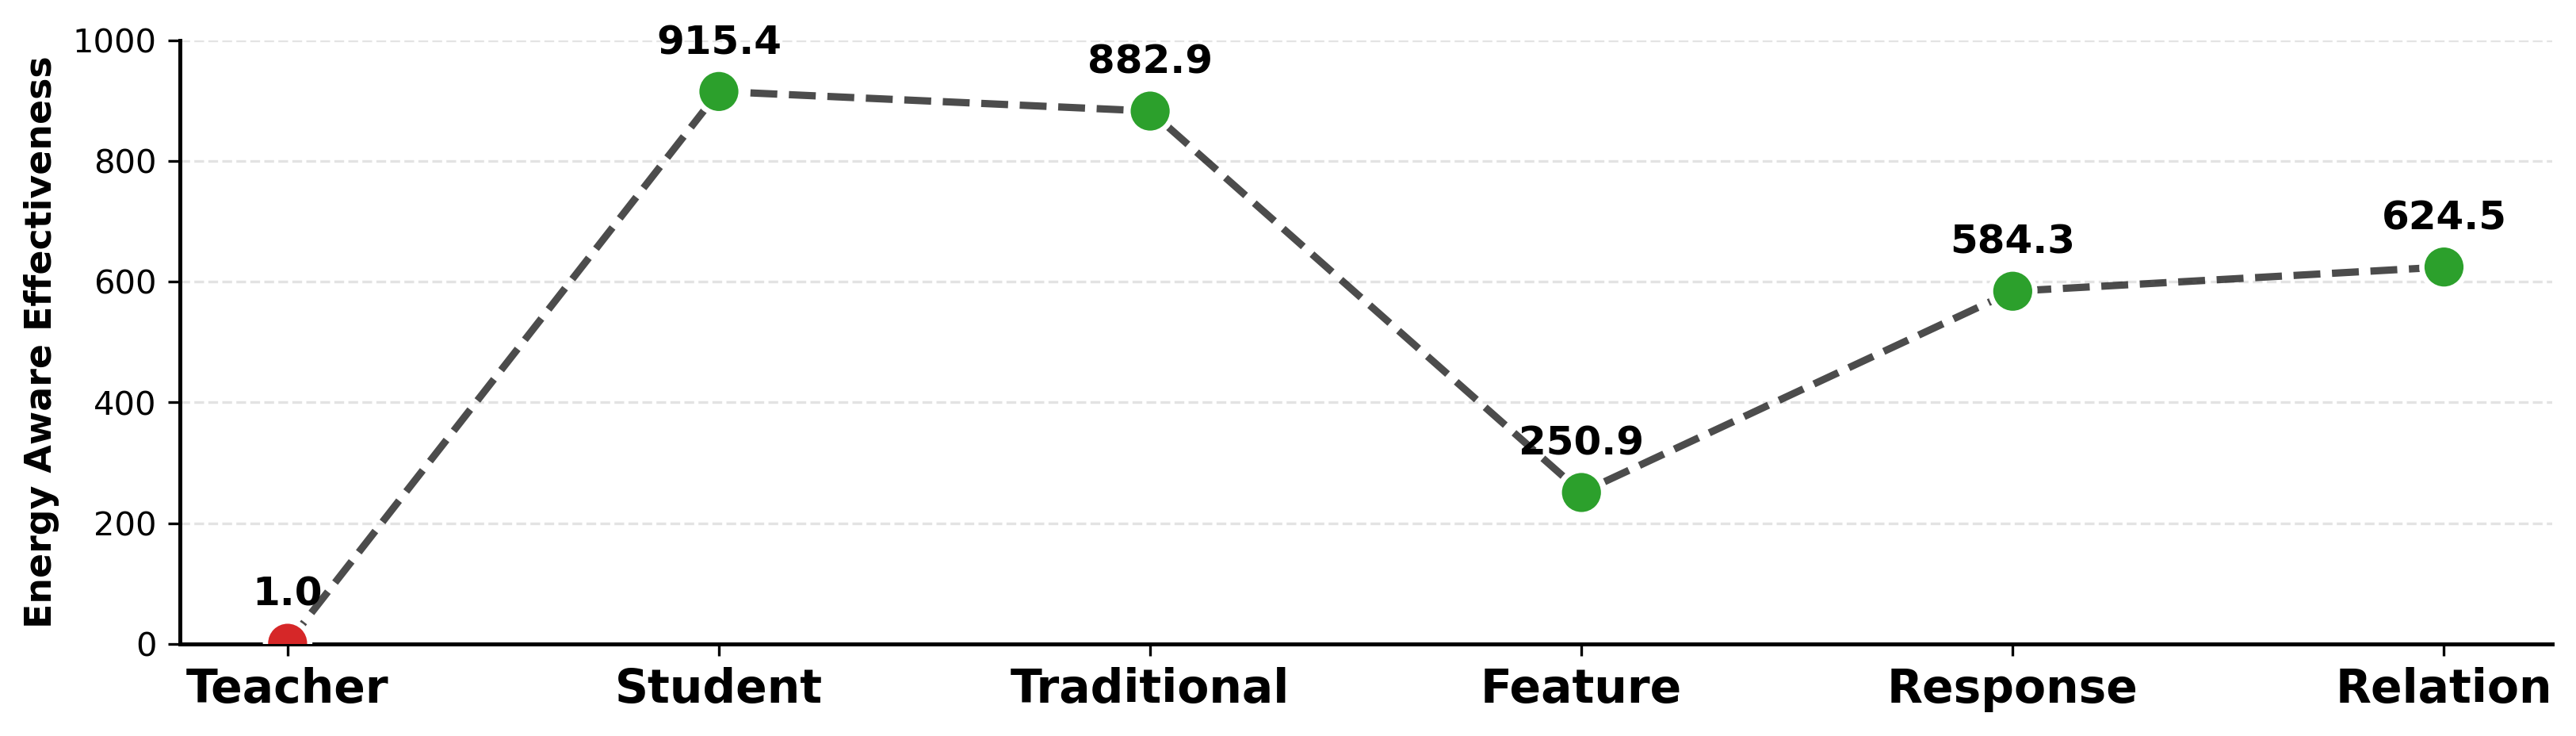

In [5]:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"]  = 42

def plot_eff_overall(eff_df: pd.DataFrame, cfg: dict):
    df = eff_df.copy()
    df["Eff_pct"] = df["Eff_overall"]
    df["Std_pct"] = df["std_eff"]

    x = np.arange(len(df))
    labels = df["Method"].astype(str).tolist()

    fig, ax = plt.subplots(figsize=(11, 3.2), dpi=300)

    ax.plot(x, df["Eff_pct"], linestyle="--", linewidth=2.2, color="black", alpha=0.7, zorder=2)
    colors = ["#d62728" if m == "Teacher" else "#2ca02c" for m in labels]

    ax.scatter(x, df["Eff_pct"], s=180, c=colors, edgecolor="white", linewidth=1.6, zorder=3)

    # error bars (only for KD)
    # for i, m in enumerate(labels):
    #     if df.loc[i, "n"] > 1 and df.loc[i, "Std_pct"] > 0:
    #         ax.errorbar(x[i], df.loc[i, "Eff_pct"], yerr=df.loc[i, "Std_pct"],
    #                     fmt="none", ecolor="black", elinewidth=1.2, capsize=5, zorder=4)

    # labels
    for xi, yi in zip(x, df["Eff_pct"]):
        ax.annotate(f"{yi:.1f}", (xi, yi), textcoords="offset points", xytext=(0, 9),
                    ha="center", va="bottom", fontsize=12, fontweight="bold")

    # ax.axhline(100, linestyle="--", linewidth=1.4, color="black", alpha=0.45)

    ax.set_xticks(x)
    ax.set_xticklabels(["Teacher", "Student", "Traditional", "Feature", "Response", "Relation"],
                       fontsize=14, fontweight="bold")
    ax.set_ylabel("Energy Aware Effectiveness", fontsize=11, fontweight="bold")

    ax.set_ylim(0, 1000)  # change freely
    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    fig.tight_layout()

    cfg["OUTDIR"].mkdir(parents=True, exist_ok=True)
    # fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.pdf", bbox_inches="tight", dpi=600)
    # fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.svg", bbox_inches="tight")

    return fig, ax

fig, ax = plot_eff_overall(eff_df, CFG)
plt.show()


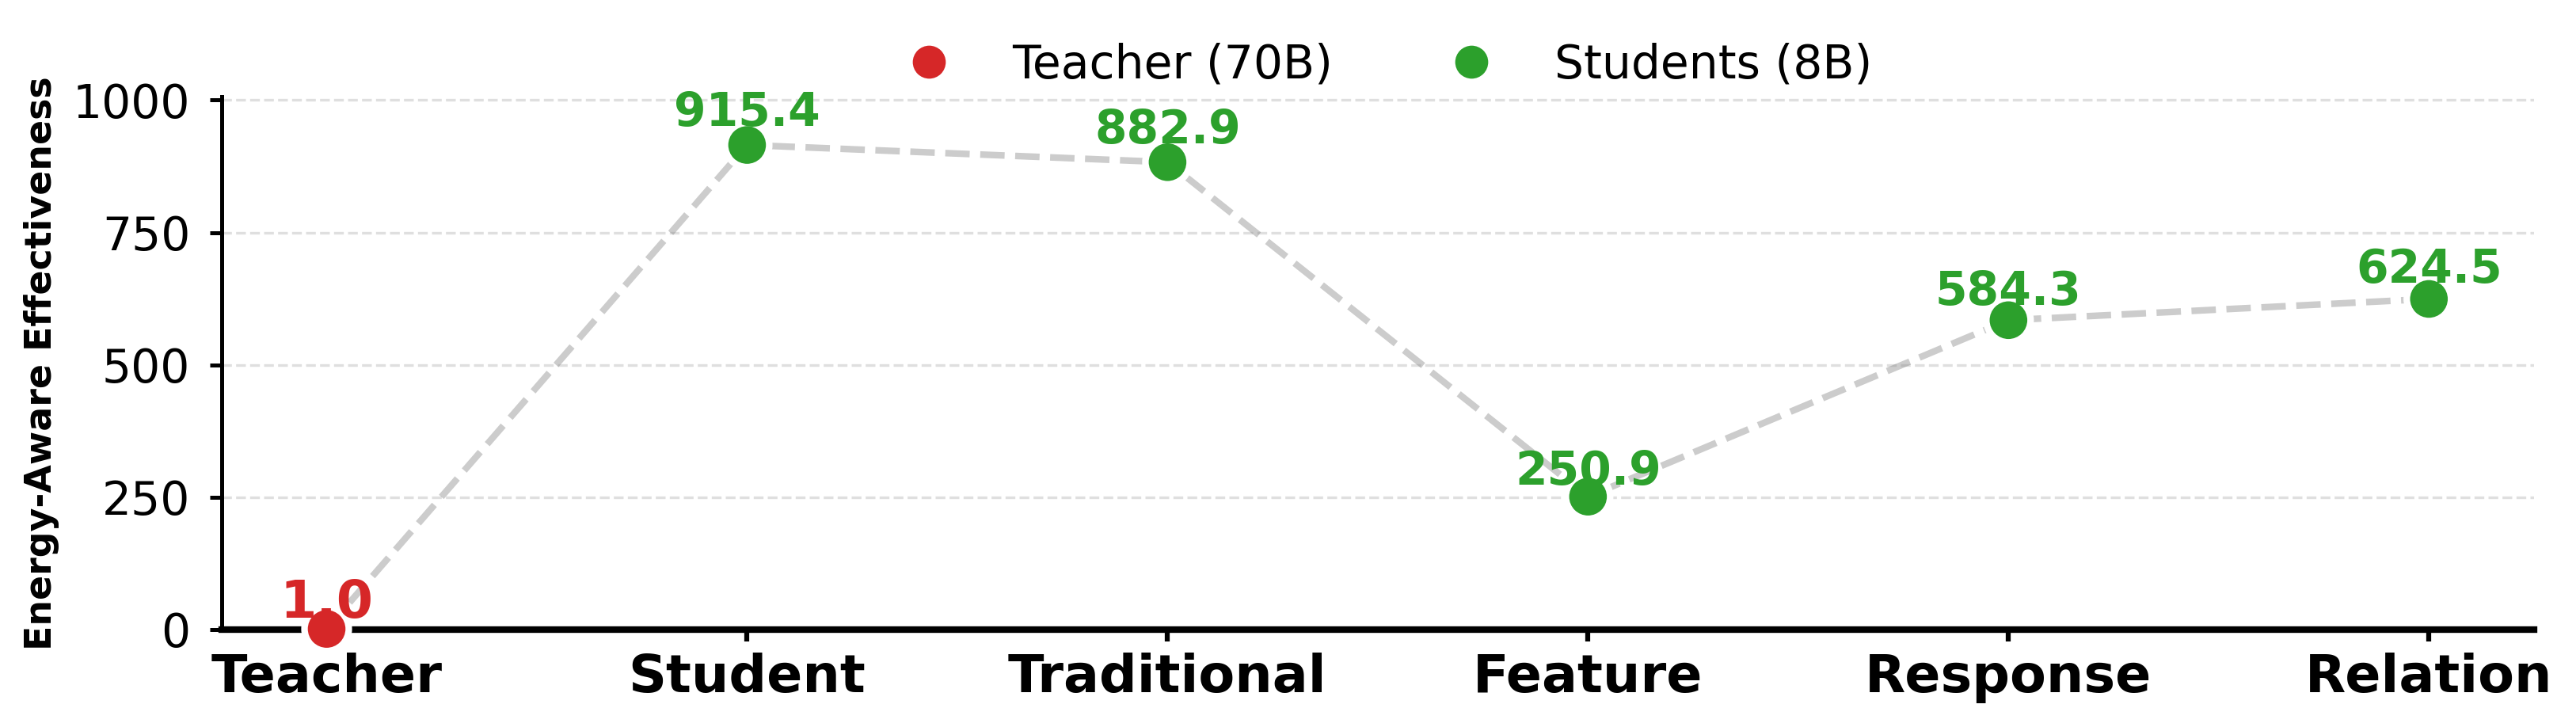

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

# ---- Global style consistency ----
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"]  = 42

COLOR_TEACHER = "#d62728"
COLOR_STUDENT = "#2ca02c"
COLOR_TREND   = "gray"


def plot_eff_overall(eff_df: pd.DataFrame, cfg: dict):
    df = eff_df.copy()
    df["Eff_pct"] = df["Eff_overall"]
    df["Std_pct"] = df["std_eff"]

    x = np.arange(len(df))
    labels = df["Method"].astype(str).tolist()

    fig, ax = plt.subplots(figsize=(11, 3.2), dpi=300)

    # ---- Trend line (EPT style) ----
    ax.plot(
        x, df["Eff_pct"],
        linestyle="--",
        linewidth=2.0,
        color=COLOR_TREND,
        alpha=0.4,
        zorder=1
    )

    # ---- Points ----
    colors = [COLOR_TEACHER if m == "Teacher" else COLOR_STUDENT for m in labels]

    ax.scatter(
        x, df["Eff_pct"],
        s=180,
        c=colors,
        edgecolor="white",
        linewidth=2.0,
        zorder=3,
        clip_on=False   # 🔑 prevents top-point clipping
    )

    # ---- Value annotations (bold, color-coded) ----
    for xi, yi, m in zip(x, df["Eff_pct"], labels):
        ax.text(
            xi, yi * 1.02,            # multiplicative offset (scale-safe)
            f"{yi:.1f}",
            ha="center",
            va="bottom",
            fontsize=16 if m == "Teacher" else 14,
            fontweight="bold",
            color=COLOR_TEACHER if m == "Teacher" else COLOR_STUDENT
        )

    # ---- Axes ----
    ax.set_xticks(x)
    ax.set_xticklabels(
        ["Teacher", "Student", "Traditional", "Feature", "Response", "Relation"],
        fontsize=15,
        fontweight="bold"
    )

    ax.set_ylabel("Energy-Aware Effectiveness", fontsize=11, fontweight="bold")

    # ---- Y range with headroom (prevents marker clipping) ----
    ymax = df["Eff_pct"].max()
    ax.set_ylim(0, ymax * 1.1)

    # ---- Grid & spines (EPT look) ----
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.grid(False, axis="x")
    ax.set_axisbelow(True)

    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(2.0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.tick_params(axis="y", labelsize=14, width=1.2, pad=6)
    ax.tick_params(axis="x", labelsize=16, width=1.5)

    from matplotlib.lines import Line2D

    legend_handles = [
        Line2D([0], [0],
               marker="o",
               color="none",
               markerfacecolor=COLOR_TEACHER,
               markeredgecolor="white",
               markeredgewidth=2,
               markersize=12,
               label="Teacher (70B)"),
        Line2D([0], [0],
               marker="o",
               color="none",
               markerfacecolor=COLOR_STUDENT,
               markeredgecolor="white",
               markeredgewidth=2,
               markersize=12,
               label="Students (8B)"),
    ]
    
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),  # above plot, same as OM / EPT
        ncol=2,
        frameon=False,
        fontsize=14
    )

    
    fig.tight_layout()

    # ---- Save ----
    cfg["OUTDIR"].mkdir(parents=True, exist_ok=True)
    fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.pdf", bbox_inches="tight", dpi=600)
    fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.svg", bbox_inches="tight")

    return fig, ax
    
fig, ax = plot_eff_overall(eff_df, CFG)
plt.show()